# PS6 QRM

##### Antoine BEDANIAN Nicolas de LESTABLE Maxime RICHIARDI Ivan SCHOENENBERGER

In [25]:
#import
#!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
from datetime import datetime as dt
from scipy.stats import norm,t 
from scipy.optimize import minimize, LinearConstraint, Bounds
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
def period(df,start,end):
    start = dt.strptime(start, '%d-%m-%Y')
    end = dt.strptime(end, '%d-%m-%Y')
    mask = (df.index >= start) & (df.index <= end)
    return df.loc[mask]

In [3]:
#import data for Microsoft
ticker = "MSFT"
df = yf.Ticker(ticker)
price = df.history(period="max")['Close']
returns = np.log(price).diff()
returns.dropna(inplace=True)

start = "07-04-2011"
end = "07-04-2016"

returns =  period(returns,start,end)
n = len(returns)

## Normal Law

In [4]:
#Loss function
def L(X,*args):
    alpha0 = X[0]
    alpha1 = X[1]
    beta1 =  X[2]
    x = args[0]
    std0 = args[1]
    sigma = [std0]
    for i in range(len(x)):
        sigma += [np.sqrt(alpha0 + alpha1*(x[i]**2) + beta1*(sigma[-1]**2))]
    Loss = [-np.log(sigma[i])+np.log(norm.pdf(x[i]/sigma[i])) for i in range(len(x))]
    return -np.sum(Loss)

#minimize function 
def GARCH(rt,X0):
    mu0 = np.mean(rt)
    std0 = np.std(rt)
    bnd = Bounds([10**(-8),0,0], [np.inf,np.inf,np.inf], keep_feasible=True)
    result = minimize(L,x0=X0,method='SLSQP',args=(rt-mu0,std0),bounds=bnd)
    return result.x,result.fun

In [5]:
index_0 = 501
x0 = [0.4,0.1,0.8]
res = []
for i in range(n - index_0):
    ri = returns.iloc[i:i+index_0]
    res += [GARCH(ri,x0)]

In [8]:
#save GARCH parameters for the normal law
np.save('res',res, allow_pickle=True, fix_imports=True)

In [12]:
#Computing the VAR
sigma_prec = np.std(returns.iloc[0:index_0])
VaR95 = []
VaR99 = []
sigma_new = []
for i in range(len(res)):
    if np.abs(res[i][1]) > 1300:
        param = res[i][0]       
    xi = returns.iloc[i:i+index_0]
    mu = np.mean(xi)
    sigma_new += [np.sqrt(param[0] + param[1]*((returns.iloc[i+index_0]-mu)**2) + param[2]*(sigma_prec**2))]
    VaR95 += [norm.ppf(0.975)*sigma_new[-1] - mu]
    VaR99 += [norm.ppf(0.995)*sigma_new[-1] - mu]
    sigma_prec = sigma_new[-1]

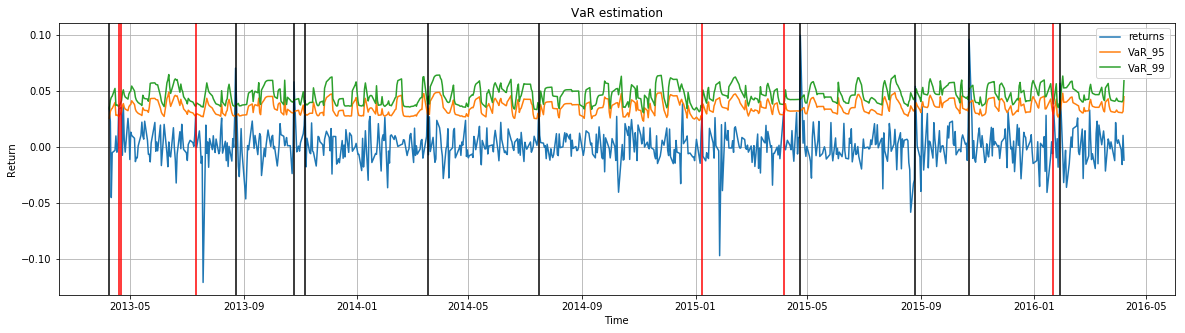

In [14]:
#Plot the VAR
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(returns.iloc[index_0+1:],label='returns')
plt.plot(returns.index.values[index_0+1:],VaR95[:-1],label='VaR_95')
plt.plot(returns.index.values[index_0+1:],VaR99[:-1],label='VaR_99')
for i in range(len(returns.iloc[index_0+1:])):
    if returns.iloc[index_0+1+i]>VaR95[i] and returns.iloc[index_0+1+i]>VaR99[i]:
        plt.axvline(x=returns.index.values[index_0+1+i],color='black') #if it breaches both var : BLACK
    elif returns.iloc[index_0+1+i]>VaR95[i] and returns.iloc[index_0+1+i]<VaR99[i]:
        plt.axvline(x=returns.index.values[index_0+1+i],color='red') #if it only breaches var95 : RED
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.title('VaR estimation')
plt.show()

We plot the breach in black for the 99% VaR in red for the 95% VaR. 

#### 4)

## Student Law 

In [15]:
def L_t(X,*args):
    alpha0 = X[0]
    alpha1 = X[1]
    beta1 =  X[2]
    nu = X[3]
    x = args[0]
    std0 = args[1]
    sigma = [std0]
    cst = np.sqrt(int(nu)/(int(nu)-2+10**(-6)))
    for i in range(len(x)):
        sigma.append(np.sqrt(alpha0 + alpha1*(x[i]**2) + beta1*(sigma[-1]**2)))
    Loss = [np.log(cst/sigma[i])+np.log(cst*t.pdf(x[i]/sigma[i],int(nu))) for i in range(len(x))]
    return -np.sum(Loss)

def GARCH_t(rt,X0):
    mu = np.mean(rt)
    std0 = np.std(rt)
    bound = Bounds([10**(-8),0,0,2.00001], [np.inf,np.inf,np.inf,np.inf], keep_feasible=True)
    res = minimize(L_t,x0=X0,method='SLSQP',args=(returns-mu,std0),bounds=bound)
    return res.x,res.fun

In [26]:
index_0 = 501
x0 = [0.4,0.1,0.8,1]
res_t = []
for i in tqdm(range(n - index_0)):
    ri = returns.iloc[i:i+index_0]
    res_t += [GARCH_t(ri,x0)]

100%|██████████| 757/757 [5:34:08<00:00, 20.07s/it]  


In [27]:
#save GARCH parameters for the student law
np.save('res_t',res_t, allow_pickle=True, fix_imports=True)

In [39]:
#Computing the VAR for the student
sigma_prec_t = np.std(returns.iloc[0:index_0])
VaR95_t = []
VaR99_t = []
sigma_new_t = []
for i in range(len(res)):
    if np.abs(res_t[i][1]) > 1300:
        param = res_t[i][0]       
    xi = returns.iloc[i:i+index_0]
    mu_t = np.mean(xi)
    sigma_new_t += [np.sqrt(param[0] + param[1]*((returns.iloc[i+index_0]-mu_t)**2) + param[2]*(sigma_prec_t**2))]
    VaR95_t += [norm.ppf(0.975)*sigma_new_t[-1] - mu_t]
    VaR99_t += [norm.ppf(0.995)*sigma_new_t[-1] - mu_t]
    sigma_prec_t = sigma_new_t[-1]

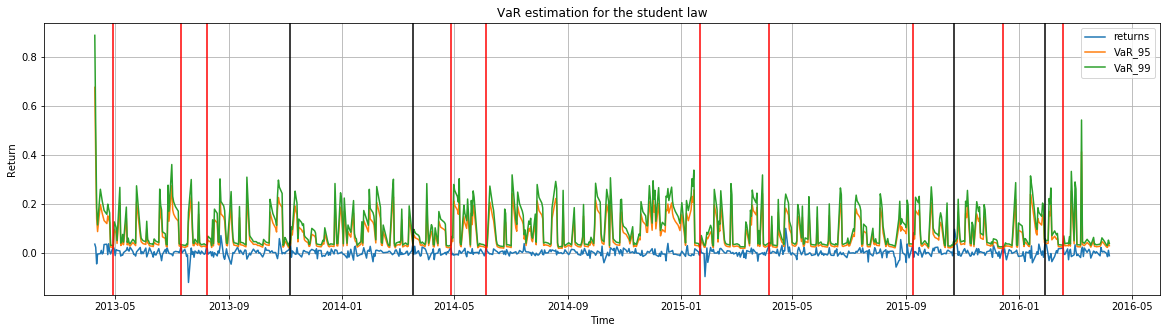

In [40]:
#Plot the VAR student
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(returns.iloc[index_0+1:],label='returns')
plt.plot(returns.index.values[index_0+1:],VaR95_t[:-1],label='VaR_95')
plt.plot(returns.index.values[index_0+1:],VaR99_t[:-1],label='VaR_99')
for i in range(len(returns.iloc[index_0+1:])):
    if returns.iloc[index_0+1+i]>VaR95_t[i] and returns.iloc[index_0+1+i]>VaR99_t[i]:
        plt.axvline(x=returns.index.values[index_0+1+i],color='black') #if it breaches both var : BLACK
    elif returns.iloc[index_0+1+i]>VaR95_t[i] and returns.iloc[index_0+1+i]<VaR99_t[i]:
        plt.axvline(x=returns.index.values[index_0+1+i],color='red') #if it only breaches var95 : RED
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.title('VaR estimation for the student law')
plt.show()

We plot the breach in black for the 99% VaR in red for the 95% VaR. 

#### 5)

We check that the sum of the coefficient is less than 1. This allows us to compute the variance of Xt implied by the parameters in each case. We plot the empirical variance of the two year moving window of returns, as well as the theoretical variance given by the estimated model using the normal and the student distribution.

In [33]:
# for the normal distribution
res = np.load('res.npy',allow_pickle=True)
l = []
for i in range(0,len(res)):
    l+=[res[i][0]]
l = np.array(l)
#checking that all the value ar below 1 
(np.sum(l,axis = 1) < 1).all()

True

In [34]:
# for the student distribution
res_t = np.load('res_t.npy',allow_pickle=True)
l_t = []
for i in range(0,len(res_t)):
    l_t+=[res[i][0]]
l_t = np.array(l_t)
#checking that all the value ar below 1 
(np.sum(l_t,axis = 1) < 1).all()

True

In [60]:
#Computing the empirical var
var_l = []
for i in range(n - index_0):
    ri = returns.iloc[i:i+index_0]
    var_l += [np.var(ri)]

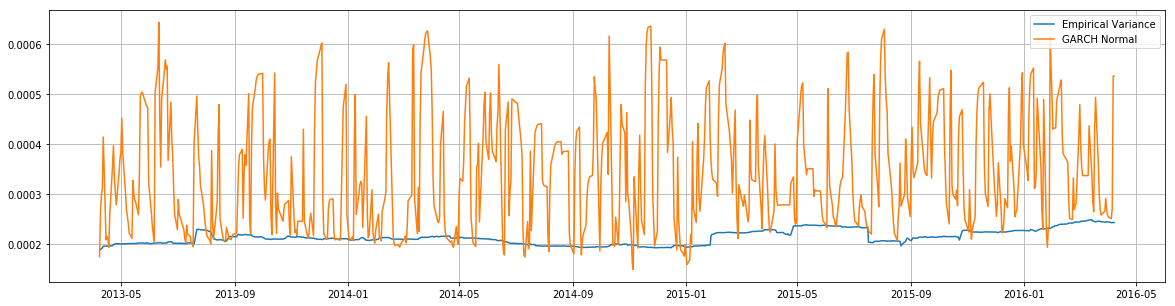

In [63]:
plt.figure(figsize=(20,5))
plt.grid(True)
plt.plot(returns.index.values[index_0:],var_l,label='Empirical Variance')
plt.plot(returns.index.values[index_0:],np.power(sigma_new,2),label='GARCH Normal')
#plt.plot(returns.index.values[index_0:],np.power(sigma_new_t,2),label='GARCH Student')
plt.legend()
plt.show()